In [347]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from datetime import datetime

In [348]:
df = pd.read_csv('SUM_DATA.csv')
# df = pd.read_csv('data.csv')

In [349]:
df = df.drop('STORE', axis=1)

In [350]:
df.head()

,SALE_DT,SALES
0,2019-01,6.116698e+08
1,2019-02,6.254852e+08
2,2019-03,7.278651e+08
3,2019-04,6.499091e+08
4,2019-05,6.118044e+08


In [351]:
df.columns = ['Month', 'Sales']
df.head()

,Month,Sales
0,2019-01,6.116698e+08
1,2019-02,6.254852e+08
2,2019-03,7.278651e+08
3,2019-04,6.499091e+08
4,2019-05,6.118044e+08


In [352]:
df.shape

(42, 2)

In [353]:
df.isnull().sum()

Month    0
Sales    0
dtype: int64

In [354]:
df.tail()

,Month,Sales
37,2022-02,5.327292e+08
38,2022-03,7.537410e+08
39,2022-04,6.054326e+08
40,2022-05,5.480671e+08
41,2022-06,5.027106e+08


In [355]:
df.shape

(42, 2)

In [356]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [357]:
df['Month'] = pd.to_datetime(df['Month'])

In [358]:
df.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

In [359]:
df.head()

,Month,Sales
0,2019-01-01,6.116698e+08
1,2019-02-01,6.254852e+08
2,2019-03-01,7.278651e+08
3,2019-04-01,6.499091e+08
4,2019-05-01,6.118044e+08


In [360]:
df.set_index('Month', inplace=True)

In [361]:
df.head()

,Sales
Month,
2019-01-01,6.116698e+08
2019-02-01,6.254852e+08
2019-03-01,7.278651e+08
2019-04-01,6.499091e+08
2019-05-01,6.118044e+08


In [362]:
df.describe()

,Sales
count,4.200000e+01
mean,5.574131e+08
std,1.139248e+08
min,3.519605e+08
25%,4.789646e+08
50%,5.457878e+08
75%,6.101105e+08
max,8.893998e+08


<Axes: xlabel='Month'>

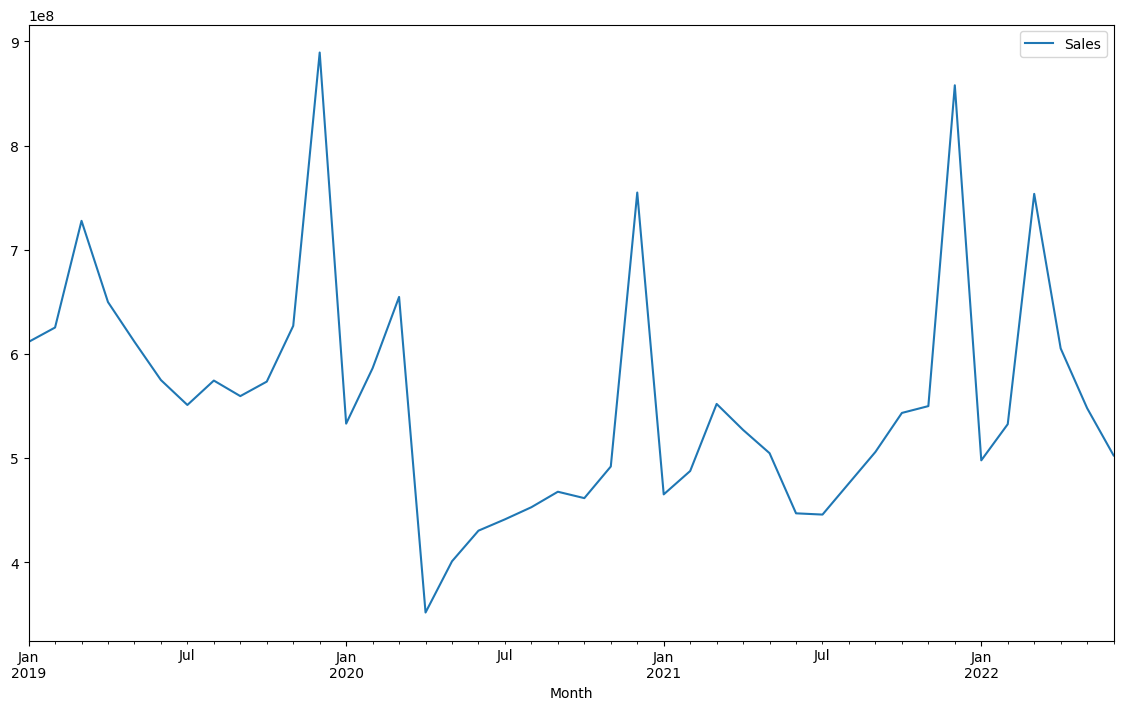

In [363]:
df.plot(figsize=(14,8))


In [364]:
adfuller(df['Sales'])

(-4.821488413501406,
 4.946542437323099e-05,
 0,
 41,
 {'1%': -3.60098336718852,
  '5%': -2.9351348158036012,
  '10%': -2.6059629803688282},
 1245.739920785457)

In [365]:
def adfuller_test(sales):
    result = adfuller(sales)
    
    labels = ['Статистика теста ADF', 'P-значение', 'Используемые лаги', 'Критерий ADF']
    
    for value, label in zip(result, labels):
        print(f'{label}, {value}')

    if result[1]<=0.05:
        print('Данные стационарны')
    else:
        print('Данные не стационарны')

In [366]:
adfuller_test(df['Sales'])

Статистика теста ADF, -4.821488413501406
P-значение, 4.946542437323099e-05
Используемые лаги, 0
Критерий ADF, 41
Данные стационарны


In [367]:
df

,Sales
Month,
2019-01-01,6.116698e+08
2019-02-01,6.254852e+08
2019-03-01,7.278651e+08
2019-04-01,6.499091e+08
2019-05-01,6.118044e+08
2019-06-01,5.750736e+08
2019-07-01,5.511557e+08
2019-08-01,5.745834e+08
2019-09-01,5.596533e+08


In [368]:
df['Sales'].shift(1)

Month
2019-01-01             NaN
2019-02-01    6.116698e+08
2019-03-01    6.254852e+08
2019-04-01    7.278651e+08
2019-05-01    6.499091e+08
2019-06-01    6.118044e+08
2019-07-01    5.750736e+08
2019-08-01    5.511557e+08
2019-09-01    5.745834e+08
2019-10-01    5.596533e+08
2019-11-01    5.735714e+08
2019-12-01    6.270833e+08
2020-01-01    8.893998e+08
2020-02-01    5.332384e+08
2020-03-01    5.864687e+08
2020-04-01    6.548460e+08
2020-05-01    3.519605e+08
2020-06-01    4.011334e+08
2020-07-01    4.305238e+08
2020-08-01    4.413847e+08
2020-09-01    4.530366e+08
2020-10-01    4.678771e+08
2020-11-01    4.617411e+08
2020-12-01    4.920891e+08
2021-01-01    7.550166e+08
2021-02-01    4.653435e+08
2021-03-01    4.877776e+08
2021-04-01    5.521452e+08
2021-05-01    5.271996e+08
2021-06-01    5.048700e+08
2021-07-01    4.471601e+08
2021-08-01    4.459584e+08
2021-09-01    4.760269e+08
2021-10-01    5.060857e+08
2021-11-01    5.435085e+08
2021-12-01    5.500617e+08
2022-01-01    8.579605

In [369]:
df['Sales first diff.'] = df['Sales'] - df['Sales'].shift(1)

In [370]:
df.head()

,Sales,Sales first diff.
Month,,
2019-01-01,6.116698e+08,NaN
2019-02-01,6.254852e+08,1.381540e+07
2019-03-01,7.278651e+08,1.023798e+08
2019-04-01,6.499091e+08,-7.795598e+07
2019-05-01,6.118044e+08,-3.810472e+07


In [371]:
df['Seasonal first diff.'] = df['Sales'] - df['Sales'].shift(12)

In [372]:
df.head()

,Sales,Sales first diff.,Seasonal first diff.
Month,,,
2019-01-01,6.116698e+08,NaN,NaN
2019-02-01,6.254852e+08,1.381540e+07,NaN
2019-03-01,7.278651e+08,1.023798e+08,NaN
2019-04-01,6.499091e+08,-7.795598e+07,NaN
2019-05-01,6.118044e+08,-3.810472e+07,NaN


In [373]:
adfuller_test(df['Seasonal first diff.'].dropna())

Статистика теста ADF, -2.097711671011186
P-значение, 0.24543574514074784
Используемые лаги, 0
Критерий ADF, 29
Данные не стационарны


## Seasonal first diff

<Axes: xlabel='Month'>

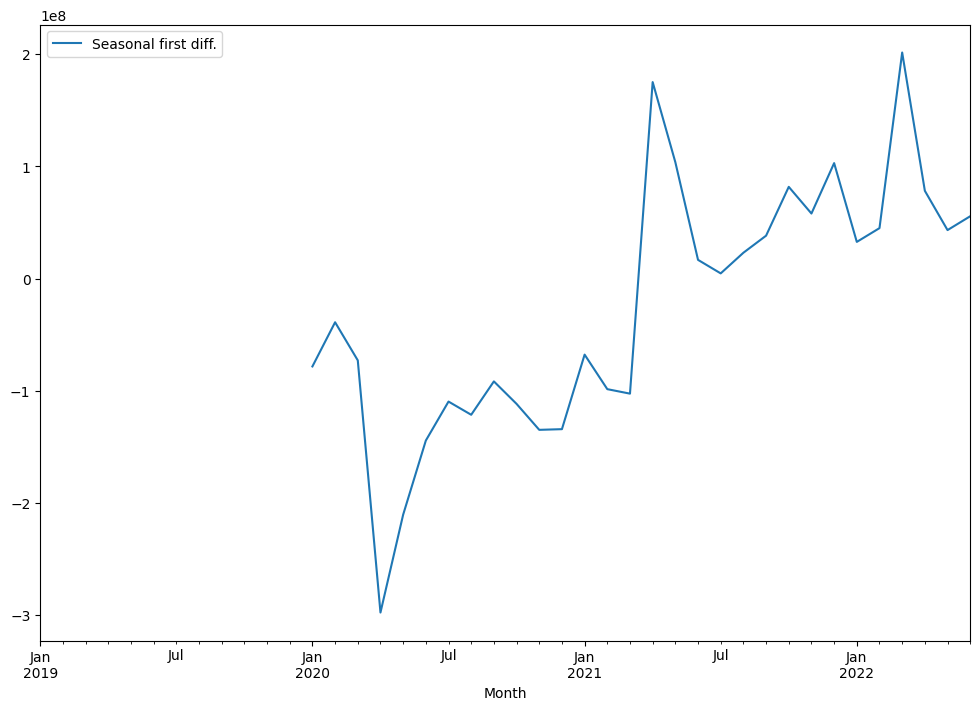

In [374]:
# df['Seasonal first diff.'].plot()
df[['Seasonal first diff.']].plot(figsize=(12,8))
# plt.ylabel('Seasonal first diff')

In [375]:
df.head(15)

,Sales,Sales first diff.,Seasonal first diff.
Month,,,
2019-01-01,6.116698e+08,NaN,NaN
2019-02-01,6.254852e+08,1.381540e+07,NaN
2019-03-01,7.278651e+08,1.023798e+08,NaN
2019-04-01,6.499091e+08,-7.795598e+07,NaN
2019-05-01,6.118044e+08,-3.810472e+07,NaN
2019-06-01,5.750736e+08,-3.673080e+07,NaN
2019-07-01,5.511557e+08,-2.391781e+07,NaN
2019-08-01,5.745834e+08,2.342769e+07,NaN
2019-09-01,5.596533e+08,-1.493012e+07,NaN


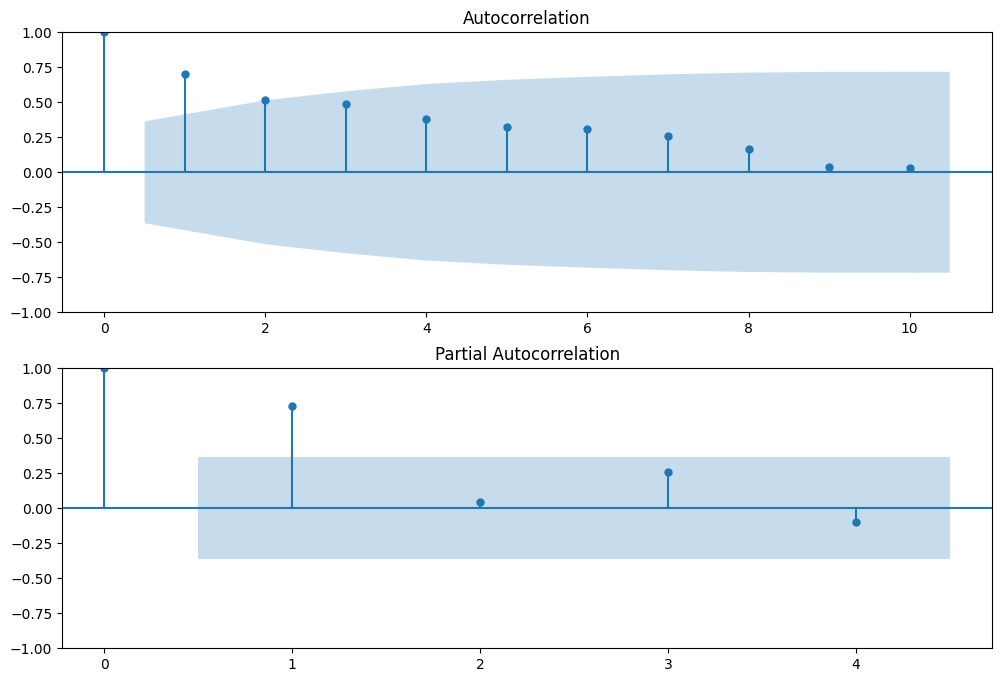

In [376]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal first diff.'].iloc[13:], lags=10, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal first diff.'].iloc[13:], lags=4, ax=ax2)

In [377]:
model = ARIMA(df['Sales'], order=(1,1,1))

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [ ]:
model = model.fit()

In [ ]:
model.summary()

In [ ]:
df.shape

In [ ]:
# df['forecast'] = model.predict(start=35, end=42, dynamic=True)

In [ ]:
# df.tail(20)

In [ ]:
# df[['Sales', 'forecast']].plot(figsize=(12,8))

## Построение модели SARIMA

In [ ]:
model = sm.tsa.statespace.SARIMAX(df['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))

In [ ]:
results = model.fit()

In [ ]:
df['forecast_SARIMAX'] = results.predict(start=20, end=42, dynamic=True)

In [ ]:
df.tail(20)

In [ ]:
df[['Sales','forecast_SARIMAX']].plot(figsize=(12,8))

## На графике видим, что модель SARIMAX показывает довольно точный прогноз, но видны расхождения

## Строим прогноз на будущие периоды

In [ ]:
future_dates = [df.index[-1] + DateOffset(months=x)for x in range(0,3)]

In [ ]:
future_dates[1:]

In [ ]:
future_dataset = pd.DataFrame(index = future_dates[1:], columns = df.columns)

In [ ]:
future_dataset.tail()

In [ ]:
future_df = pd.concat([df, future_dataset])

In [ ]:
future_df.shape

In [ ]:
future_df['forecast_SARIMAX2'] = results.predict(start=41, end=44, dynamic=True)

In [ ]:
future_df[['Sales', 'forecast_SARIMAX2']].plot(figsize=(12,8))

## Построение прогноза на 07 и 08 месяцы 2022г.

In [ ]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0, 24)]
future_dates[1:]
future_dataset = pd.DataFrame(index=future_dates[1:], columns=df.columns)
future_dataset.tail()
future_df = pd.concat([df, future_dataset])
future_df.shape
future_df['forecast_SARIMAX3'] = results.predict(start=41, end=65, dynamic=True)
future_df[['Sales', 'forecast_SARIMAX3']].plot(figsize=(12, 8))

## Бонус! Построение прогноза на последующие 2 года! =)

## Итог для построения прогноза была выбрана модель SARIMAX. Её преимущество перед ARIMA состоит  в том, что она учитывает данные с внешними факторами (сезонность, праздники и тд.)